In [29]:
# 1. Kütüphanelerin İçe Aktarılması

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

from imblearn.over_sampling import SMOTE  # SMOTE buraya eklendi


         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   
5    843786         M        12.45         15.70           82.57      477.1   
6    844359         M        18.25         19.98          119.60     1040.0   
7  84458202         M        13.71         20.83           90.20      577.9   
8    844981         M        13.00         21.82           87.50      519.8   
9  84501001         M        12.46         24.04           83.97      475.9   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760         0.30010 

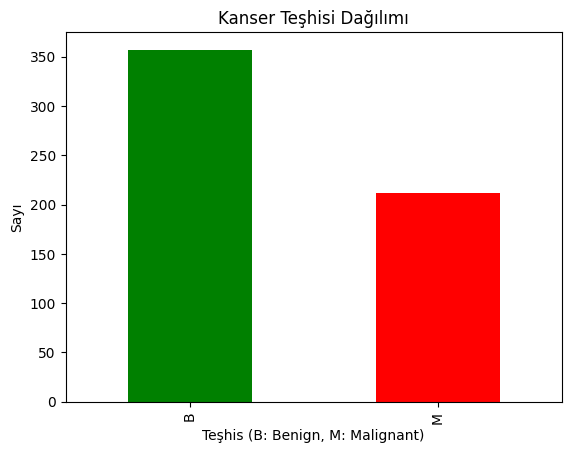

In [30]:
# 2. Veriyi Yükleme ve İlk İnceleme
# CSV dosyasını oku
kanser = pd.read_csv('breast-cancer.csv')

# İlk 10 veriye göz atalım
print(kanser.head(10))

# Veri kümesi hakkında bilgi alalım
print(kanser.info())

# Teşhis (diagnosis) sınıfının dağılımına bakalım
diagnosis_distribution = kanser['diagnosis'].value_counts()
diagnosis_distribution.plot(kind='bar', color=['green', 'red'])
plt.title('Kanser Teşhisi Dağılımı')
plt.xlabel('Teşhis (B: Benign, M: Malignant)')
plt.ylabel('Sayı')
plt.show()


In [31]:
# ✅ 3. Veri Hazırlama


# Bağımlı (tahmin edilecek) değişken: diagnosis
y = kanser[['diagnosis']]

# Bağımsız (özellik) değişkenler: id ve diagnosis hariç hepsi
x = kanser.drop(columns=['diagnosis', 'id'], axis=1)

# 'B' ve 'M' gibi harfleri sayıya çevirelim çünkü modeller sayılarla çalışır
y = y.replace({'B': 0, 'M': 1})


<ipython-input-31-d89a79d4960b>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'B': 0, 'M': 1})


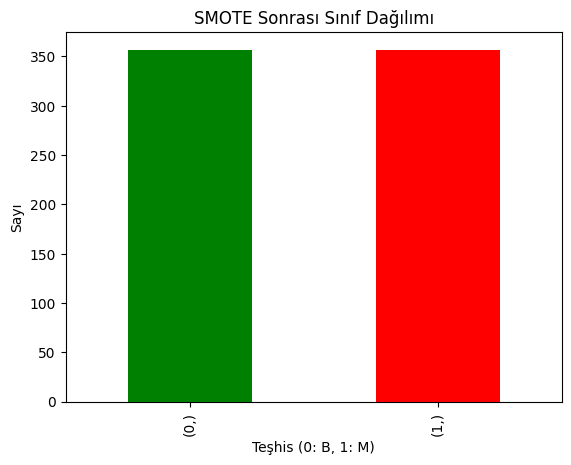

In [35]:
# 4. SMOTE ile Dengeleme
# SMOTE uygulayarak veri dengesizliğini gider
smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(x, y)

# Yeni veri setinin dağılımına bakalım
y_smote.value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("SMOTE Sonrası Sınıf Dağılımı")
plt.xlabel("Teşhis (0: B, 1: M)")
plt.ylabel("Sayı")
plt.show()


In [33]:
# 5. Veriyi Eğitim ve Test Olarak Bölme
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, train_size=0.8, random_state=34)


In [36]:
# 6. Karar Ağacı Modeli Kurma ve Eğitme


tree = DecisionTreeClassifier(random_state=42)
model = tree.fit(x_train, y_train)


Model Doğruluk Skoru: 0.958041958041958

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96        71
           1       0.95      0.97      0.96        72

    accuracy                           0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143



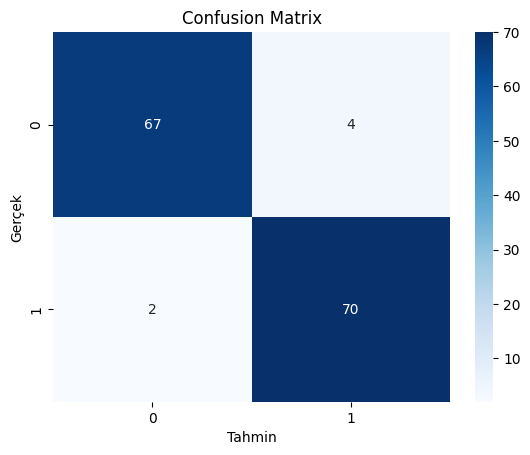

In [37]:
#  7. Modelin Performansını Ölç
# Doğruluk skoru
print("Model Doğruluk Skoru:", model.score(x_test, y_test))

# Sınıflandırma raporu
print("\nSınıflandırma Raporu:\n", classification_report(y_test, model.predict(x_test)))

# Karışıklık Matrisi
conf_mat = confusion_matrix(y_test, model.predict(x_test))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()


In [40]:
# Örnek: 10. hasta için tahmin
print("10. Hasta Tahmini:", model.predict([x.iloc[154]]))


10. Hasta Tahmini: [0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


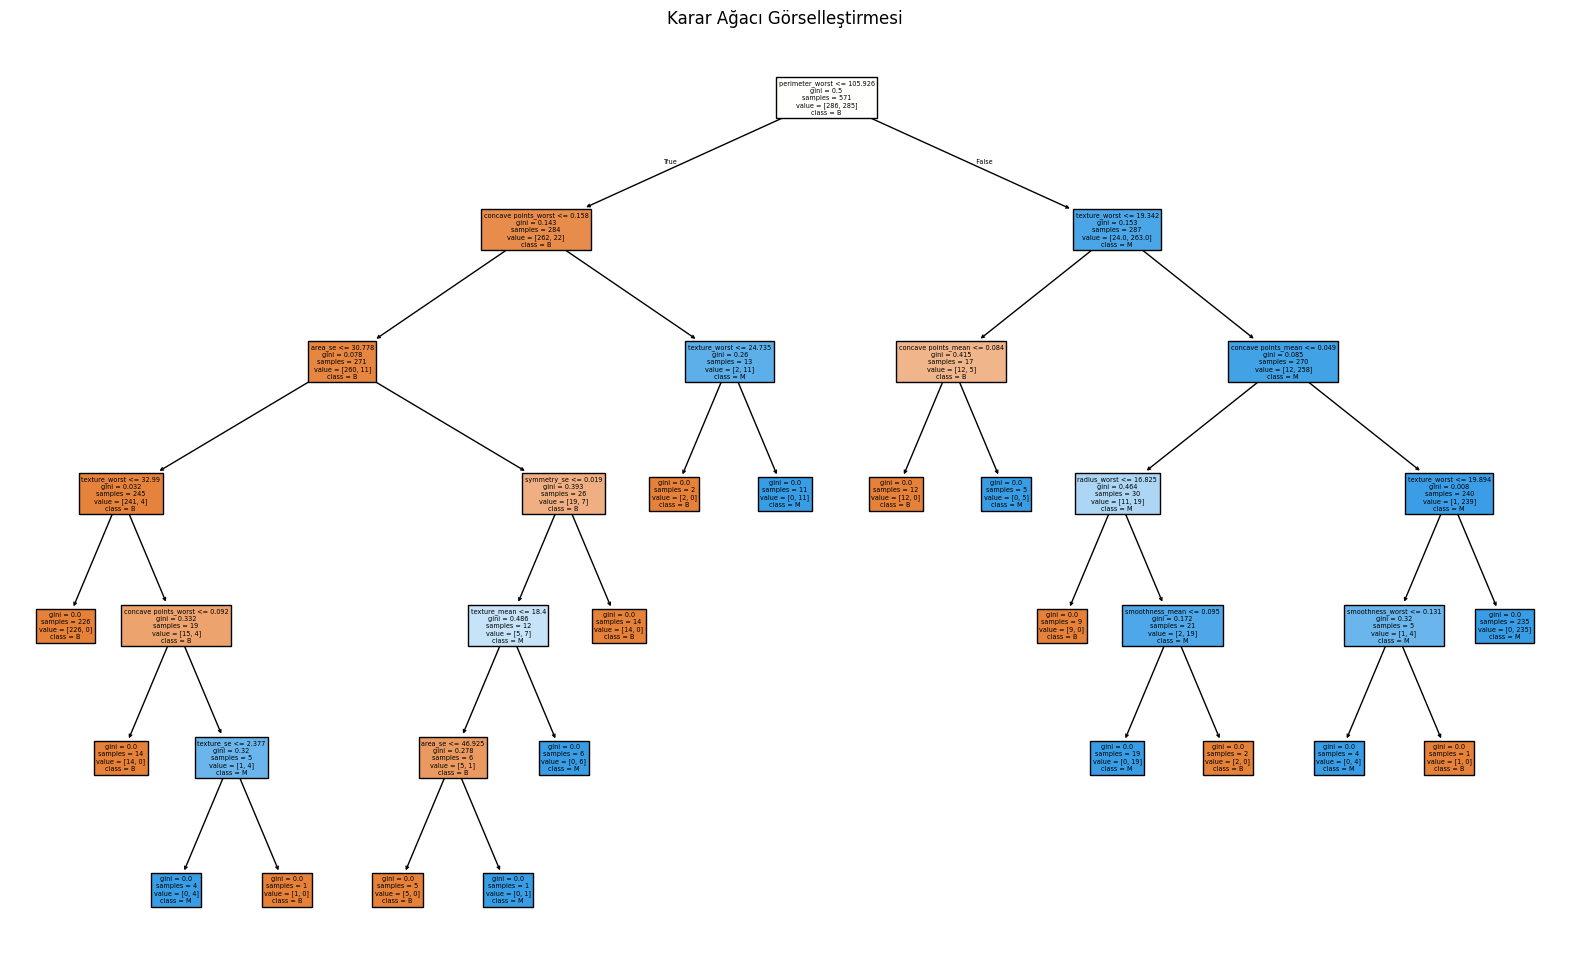

In [41]:
#  9. Karar Ağacını Görselleştir
plt.figure(figsize=(20, 12))
plot_tree(model, filled=True, feature_names=x.columns, class_names=['B', 'M'])
plt.title("Karar Ağacı Görselleştirmesi")
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


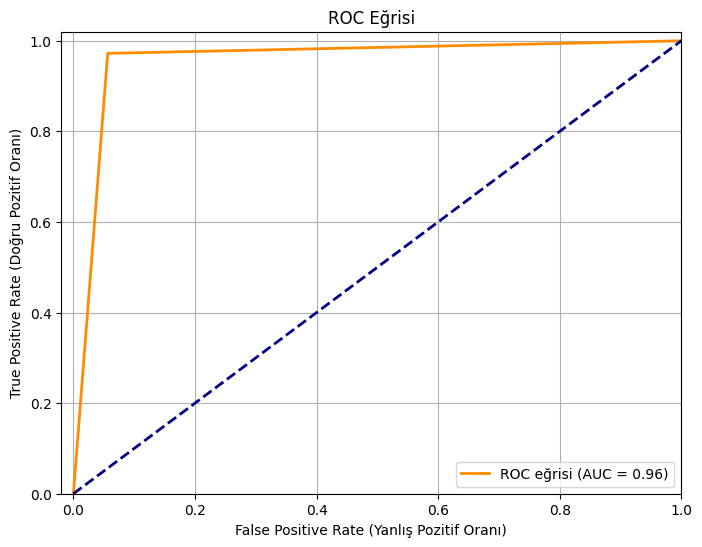

In [42]:
# 10. ROC Eğrisi ve AUC Skoru
# Önce sınıfları sayısal hale getirmemiz gerekiyor: B=0, M=1
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_pred_proba = model.predict_proba(x_test)[:, 1]  # sadece 'M' sınıfının olasılığı

# ROC eğrisi için fpr, tpr ve eşik değerleri
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)

# ROC eğrisini çiz
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC eğrisi (AUC = %0.2f)' % roc_auc_score(y_test_encoded, y_pred_proba))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate (Yanlış Pozitif Oranı)')
plt.ylabel('True Positive Rate (Doğru Pozitif Oranı)')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [43]:
# 11. AUC Skoru
auc_score = roc_auc_score(y_test_encoded, y_pred_proba)
print("AUC Skoru:", auc_score)



AUC Skoru: 0.957942097026604
